# Model Evaluation

## Import Libraries

In [6]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import cv2

from src.paths import model_dir, data_dir

## Load Model

In [1]:
model = load_model(model_dir / "best_model.keras")

✅ Directory ready: /Users/yassientawfik/Documents/Career/Projects/Elevvo Internship/DriveSafe-Sign-Detection/data
✅ Directory ready: /Users/yassientawfik/Documents/Career/Projects/Elevvo Internship/DriveSafe-Sign-Detection/outputs/figures
✅ Directory ready: /Users/yassientawfik/Documents/Career/Projects/Elevvo Internship/DriveSafe-Sign-Detection/outputs/model


2025-07-29 19:12:12.426576: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-29 19:12:12.426592: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-29 19:12:12.426594: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753805532.426603 1022221 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753805532.426620 1022221 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load and Prepare Datasets

In [20]:
test_df = pd.read_csv(data_dir / "Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [21]:
test_images = []
test_labels = []

for _, row in test_df.iterrows():
    image_path = data_dir / row["Path"]  # corrected line
    image = cv2.imread(str(image_path))

    if image is None:
        print(f"Could not read image at: {'/'.join(image_path.parts[-2:])}")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    test_images.append(image)
    test_labels.append(row["ClassId"])

x_test = np.array(test_images)
y_test = np.array(test_labels)

Could not read image at: Test/00802.png


## Predict Outputs

In [22]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2025-07-29 19:49:11.085791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


## Confusion Matrix & Report

✅ Test Accuracy: 0.055744714545886455

🧾 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.85      0.64        60
           1       0.97      0.87      0.92       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       629
           6       0.00      0.00      0.00       150
           7       0.02      0.01      0.02       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16    

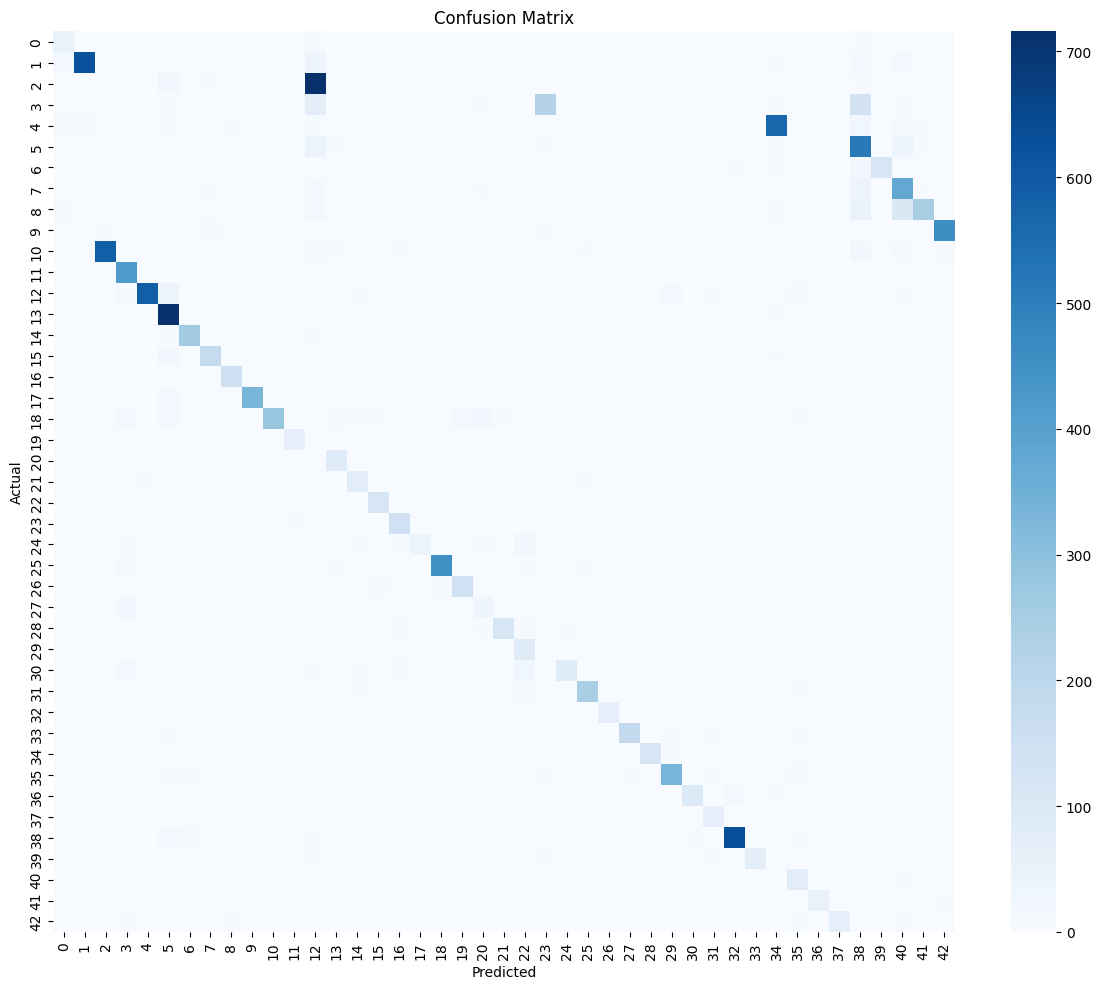

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()